In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import numpy as np
import copy
import json
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

import IPython
from IPython.display import Image as img
from IPython.display import display

from PIL import Image

import torch
import torch.nn as nn
import torchvision

In [27]:
from src.datamodules.datasets.emoreccom import EmoRecComDataset
from src.models.bert_classifier_model import BertClassifierLitModel
from src.datamodules.datasets.dataset_modality import DatasetModality
from src.datamodules.emoreccom_datamodule import EmoRecComDataModule
from src.utils.text.text_utils import merge_comic_texts

In [5]:
emoreccom_path = "/home/gsoykan20/Desktop/datasets/multimodal_emotion_recognition_on_comics_scenes/"#"/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
dataset = EmoRecComDataset(emoreccom_path, train=True)

In [6]:
len(dataset)

6112

angry 		 --> 0.0 | 0.0
disgust 	 --> 0.0 | 0.0
fear 		 --> 0.0 | 0.0
happy 		 --> 1.0 | 0.545
sad 		 --> 0.0 | 0.0
surprise 	 --> 0.0 | 0.0
neutral 	 --> 1.0 | 0.121
other 		 --> 0.0 | 0.0

### Dialogs:
-->  ten boats , one hundred men with guns ... el sheikh will not be easy to take !
-->  one of the roughest slavers in the busine sheena wait , someth coming around the now 

### Narratives:




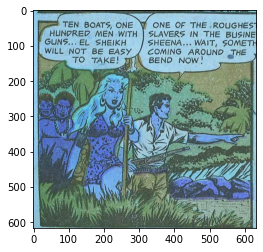

In [7]:
img, sizes, (labels, polarities), (narrative, dialog) = dataset.__getitem__(np.random.randint(dataset.__len__()))

for emotion, value, polarity in zip(dataset.emotion_list, labels, polarities):
    print(emotion, "\t\t" if len(emotion) <= 5 else "\t", "-->", value, "|", polarity)

print("\n### Dialogs:")
for d in dialog:
    print("-->", d)

print("\n### Narratives:")
for n in narrative:
    print("-->", n)

print("\n")

plt.imshow(img)

# Loading DataModule

In [29]:
use_transformer_tokenizer = True
emoreccom_path = "/home/gsoykan20/Desktop/datasets/multimodal_emotion_recognition_on_comics_scenes/"  # "/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
datamodule = EmoRecComDataModule(batch_size=1,
                                 tokenizer_max_len=80,
                                 data_dir=emoreccom_path,
                                 modality=DatasetModality.Text,
                                 use_tokenizer_instead_text_preprocessor=use_transformer_tokenizer)
datamodule.prepare_data()
datamodule.setup()
test_dataloader = iter(datamodule.test_dataloader())

In [30]:
item_index = -1

In [39]:
test_batch = next(test_dataloader)
item_index += 1

## Decode Tokenizer output back to text

In [32]:
tokenizer = datamodule.get_tokenizer()

In [33]:
data_test_copy = copy.copy(datamodule.data_test)
data_test_copy.text_transform = None

In [40]:
_, _, (_, _), (narrative, dialog) = data_test_copy[item_index]
print(merge_comic_texts((narrative, dialog)))

  ith his life flickering out as he is being choked to death , tom mix calls upon his last reserve of strength and  goodbye mix huh ! whut goes on


In [41]:
decoded_text = tokenizer.decode(test_batch[3]['ids'][0])
print(decoded_text)

[CLS] ith his life flickering out as he is being choked to death, tom mix calls upon his last reserve of strength and goodbye mix huh! whut goes on [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# Loading Trained Model


In [17]:
checkpoint_path = "/home/gsoykan20/Desktop/self_development/emotion-recognition-drawings/logs/runs/2021-11-03/19-39-22/checkpoints/epoch_063.ckpt"
# source: https://pytorch-lightning.readthedocs.io/en/latest/common/weights_loading.html
bert_emoreccom_classifier = BertClassifierLitModel.load_from_checkpoint(checkpoint_path)


Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
bert_emoreccom_classifier.eval()
bert_emoreccom_classifier.to('cpu')

BertClassifierLitModel(
  (model): BertClassifier(
    (bert): SqueezeBertModel(
      (embeddings): SqueezeBertEmbeddings(
        (word_embeddings): Embedding(30528, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): SqueezeBertEncoder(
        (layers): ModuleList(
          (0): SqueezeBertModule(
            (attention): SqueezeBertSelfAttention(
              (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
              (matmul_qk): MatMulWrapper()
              (matmul_qkv): MatMulWrapper()
  

In [19]:
with torch.no_grad():
    loss, preds, targets = bert_emoreccom_classifier.step(test_batch)


In [ ]:
# TODO: @gsoykan decode transformer ids back to sentence then see what happens

